
# Markov Chain Monte Carlo: part 2

In this blog post we continue to look at Markov Chain Monte Carlo methods for sampling distributions. The focus of the notebook is on the implementation of the algorithms rather than an explicit theoretical underpinning. In fact we will sample the same distribution a number of times via different algorithms.

In a previous pose we already discussed much of the theory of Bayseian inference and how Markov chain Monte Carlo algorithms gravitate to regions of concentrated Lebesgue measure in the posterior distribution $\pi(x)$. The focus of the post is on the *implementation* of the algorithms rather than an explicit theoretical underpinning. In fact we will sample the same distribution a number of times via different algorithms.

In some of the following algorithms it is natural to connect our distribution to thermodynamics analogies such as 'simulated annealing' or 'parallel tempering', although we do not make the connection per say, we can always redefine our target density to introduce a 'temperature' parameter $T$ with the following rescaling:

$$
p(x) = e^{-\frac{1}{T}\ln \pi(x)}
$$

Larger values of $T$ will flatten the target distribution leading to more accepted updates in the Metropolis-Hastings algorithm. We will instead take the easier road of modifying the acceptance by tuning the step size through the standard deviation of a normal distribution $Q(x'\mid x)$. Large values indicate a wide sampling that reduces accuracy, while small steps localise the sampling caused by a narrow update distribution. 

For a little change we will produce figures using matplotlib's `xkcd` style which adds a 'comic sans' feel to the graphs. This fits with the theme of this post, where nothing it trying to be too technical or precise, instead we are taking a very easy introduction to the subject and just try to get a feel for what is going on! 

We begin by importing some libraries and creating a plotting environment from plt and seaborn. This will help us to visualise the sampling algorithms more clearly. 

The main visual tool will plot the Markov chain histories and build a density plot from the samples. We also visualise the marginal densities in $x$ and $y$.  

We can also look at the *traceplots* of the samples to assess the mixing of the exploration. These are just plots of the current parameter estimate as a function of the number of samples taken. They are useful for observing the burn in period of the sampling as well as the convergence of the parameter estimate. In some cases the traceplots give tell tale signs of the sampling algorithm. 

The next diagnostic we use is the *autocorrelation* plot which baisically indicates how dependent the current parameter estimate is on the previous value. Low autocorrelation indicates samples are independent while high correlation indicates ... well ... *correlation* between points. If there is significant correlation then the effective sample size is lower than the actual number of samples recorded and can lead to inaccuracies in the estimates. 

The final indicator of convergence of the chain is the accumulate plot which graphs the running mean of the parameter values for a given iteration. If the sampler has converged then we expect the mean of the parameter to be stable. We plot these as a red curve in the traceplot and the true mean (which we hope to converge towards) as a dashed horizontal line.  

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.stats as st
from itertools import accumulate
import numpy as np
import math 
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot_dist(x,y,string):
    ''' plotting environment we frequently use to visualise the 
    sampling algorithms.'''
    
    # style for seaborn
    sns.set(style="ticks", color_codes=True)
    plt.xkcd()

    # plot contour
    g = (sns.JointGrid(x, y, size=10)
     .plot_joint(sns.kdeplot, n_levels=6, cmap="BuPu", shade=True, shade_lowest=True))

    # plot marginals 
    g = g.plot_marginals(sns.kdeplot, color="b", shade=True, shade_lowest=True)

    # add scatter plot of data
    g = g.plot_joint(plt.scatter, c="b", s=30, linewidth=1)
    plt.plot(x, y, linestyle='-', marker='o', alpha=0.4, )
    
    # set axis labels
    g.set_axis_labels("$X$", "$Y$")
    
    # save image
    plt.savefig(string)
    
def traceplot(x, string):
    '''traceplot in the x-dimension with the cumulative mean (r)
    and the actual mean (--)'''
    sns.tsplot(x)
    l = list(accumulate(x))
    nl = [v/i for i, v in enumerate(l,1)]
    plt.plot(nl, 'r')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.ylabel('x')
    plt.xlabel('Iteration')
    
    # save image
    plt.savefig(string)
    
def autocorrelation_plot(x, l, string):
    '''plots the autocorrelation of x to lag = l'''
    plt.acorr(x - np.mean(x), maxlags=l,  normed=True, usevlines=False);
    plt.xlim((0, 100))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')
    
    # save image
    plt.savefig(string)

We aren't going to be too fancy with our target distribution $\pi(x,y)$. A straightforward choice is simply a [bivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Properties) which we will visualise below.

In [3]:
# set mean and covariance for Q
mean = np.array([0, 1])
var = np.array([[1, .5], [.5, 1]])

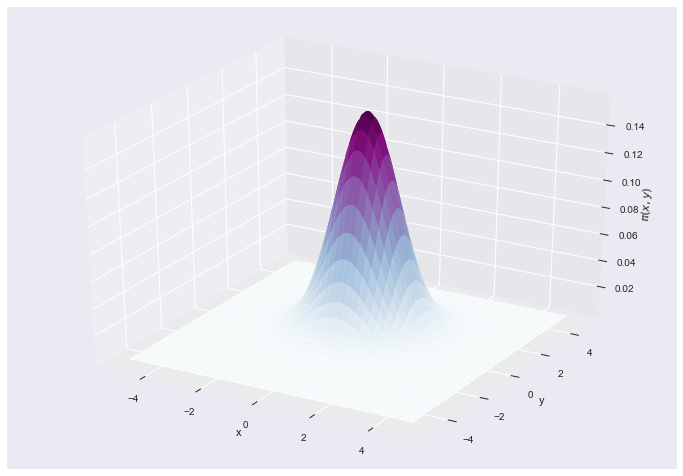

In [4]:
# create grid for 3D plot
x, y = np.linspace(-5, 5, 200), np.linspace(-5, 5, 200)
X,Y = np.meshgrid(x, y)

# generate bivariate normal 
Z = bivariate_normal(X,Y,var[0][0],var[1][1],mean[0],mean[1])

# plot surface in 3D
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= 'BuPu')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\pi(x,y)$')
plt.savefig('3D bivariate normal')

In [5]:
def ptarget(x, y):
    '''the distribution we wish to sample'''
    return st.multivariate_normal.pdf([x, y], mean=mean, cov=var)

Okay, so the first sampling algorithm is the **Metropolis-Hastings** sampler. We have discussed this before but briefly it goes as follows: propose a new set of parameters, evaluate the acceptance condition $A$, accept the update if $A$ is greater than a random number between $[0,1]$ otherwise reject the update. This iterates for $n$ moves from a starting position in the parameter space $(x_0,y_0)$. 


$$
A(\theta' \mid \theta) = \min \left( 1, \frac{\pi(\theta'\mid x)}{\pi(\theta\mid x)}\frac{Q(\theta'\mid \theta)}{Q(\theta\mid \theta')}\right)
$$

The proposals for the new states are generated from the distributions $Q$.

In [6]:
def metropolis_hastings(p, n, x0, y0, step):
    '''Samples p, the target distribution, n times according to 
    the Metropolis-Hastings algorithm starting at (x0,y0)'''

    x = x0
    y = y0
    
    points = np.zeros((n, 2)) # list of samples to fill

    for i in range(n):
        
        # propose new parameters from current state by sampling Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step,size=2)

        # Metropolis-Hastings condition
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star

        # update samples list
        points[i] = np.array([x, y])

    return points

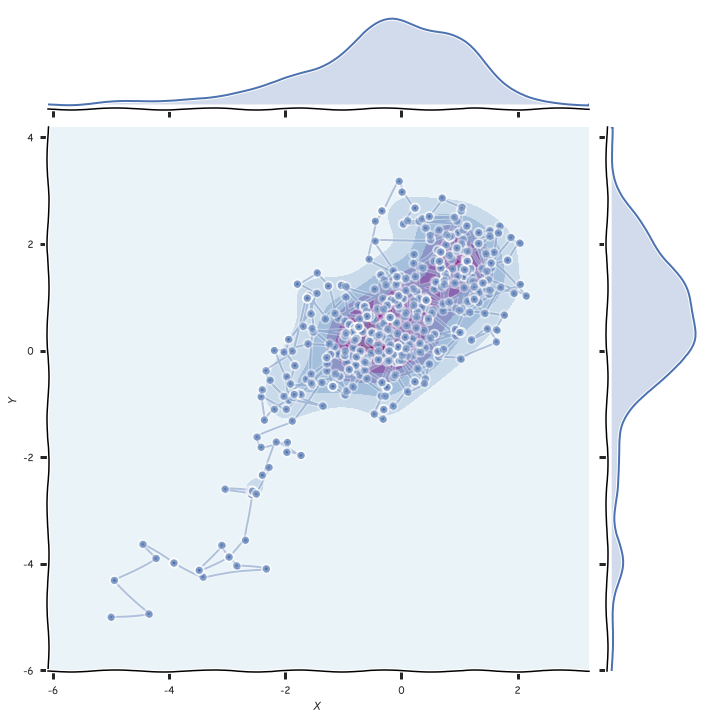

In [7]:
# generate the samples
samples = metropolis_hastings(ptarget, 500, -5, -5, 0.4)

# visualise 
plot_dist(samples[:, 0], samples[:, 1], 'metropolis_hastings')

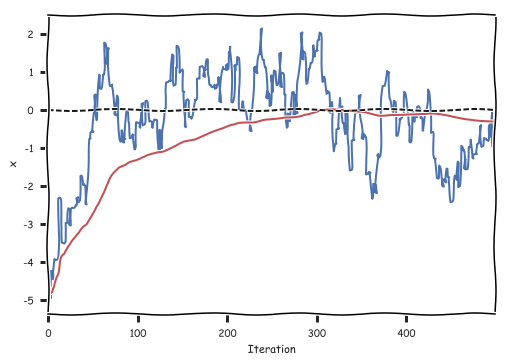

In [8]:
# traceplot in the x-dimension
traceplot(samples[:, 0], 'MH_traceplot')

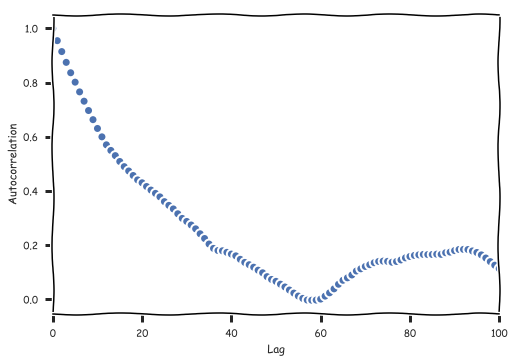

In [9]:
# autocorrelation in the x-dimension
autocorrelation_plot(samples[:, 0], 100, 'MH_auto')

So our initial guess is wayyy off at $(x,y) = (-5,-5)$ but quickly the sampler converges to regions of higher probability distribution. This is because the correcting factor that accepts the 'uphill' moves in the algorithm is drawn to regions of higher Lebesgue measure. Again we talked about that in an earlier post. As we can see from the marginal density plots (just in the $x$ and $y$ dimensions) the density estimate looks quite like the desired normal distribution.

We can see from the traceplots that the parameter space is being explored well. Initially the estimate was too low, but soon we oscillate around $x = 0$ quite evenly. The initial period prior to the oscillation is known as the 'burn in' for the Markov chain and it is good practise to disgard these samples as the algorithm has not yet found the region of concentrated measure.  

In some cases the vanilla Metropolis-Hastings algorithm will become 'stuck' in regions of the parameter space however, and it can actually be quite poor at exploring isolated modes in multimodal functions once it has found an attractive spot. In fact our next algorithm is even worse for this pitfall: **simulated annealing**. 

Simulated annealing reduces the step size of the sampling updates dynamically over the course of the process. In this way we increasingly localise on regions of more concentrated measure in the target density. This is a drawback in complicated, multimodal functions, but lets have a peak for our simple $\pi(x,y)$.  

In [50]:
def simulated_annealing(p, n, x0, y0, step):
    '''Samples p, the target distribution, n times according to 
    the Metropolis-Hastings algorithm while Q(x'|x) becomes a narrower 
    distribution. This means exploration is increasingly localised 
    along the chain '''

    global step_size
    step_size = step
    
    def anneal(step):
        global step_size 
        step_size *= 0.999
        return step_size
        
    x = x0
    y = y0
    
    points = np.zeros((n, 2)) # list of samples to fill

    for i in range(n):
        
        # propose new parameters from current state by sampling Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step_size, size=2)

        # Metropolis-Hastings condition
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star

        # update samples list
        points[i] = np.array([x, y])
        
        # reduce step size
        anneal(step_size)

    return points

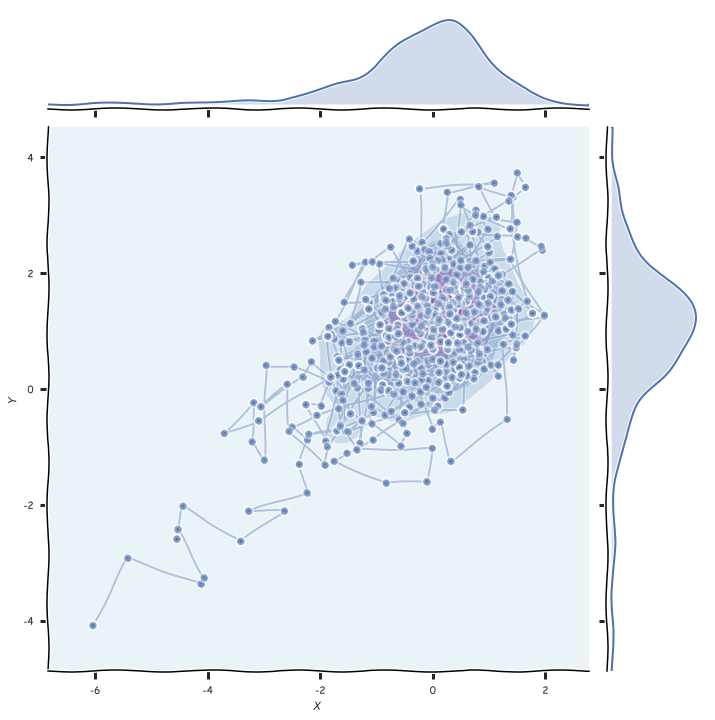

In [54]:
# generate the samples
samples = simulated_annealing(ptarget, 800, -5, -5, 0.8)

# visualise 
plot_dist(samples[:, 0], samples[:, 1], 'simulated_annealing')

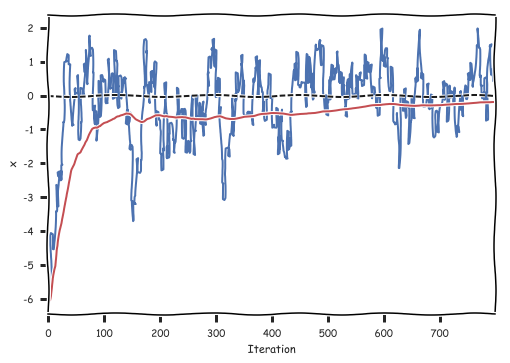

In [55]:
# traceplot in the x-dimension
traceplot(samples[:, 0], 'SA_traceplot')

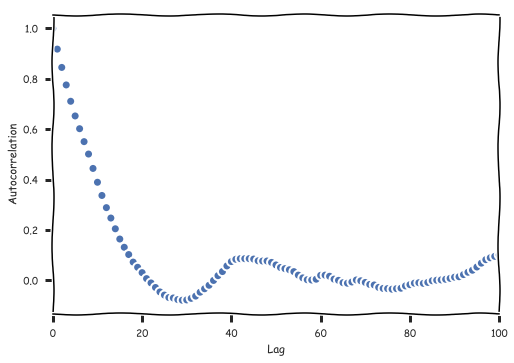

In [56]:
# autocorrelation in the x-dimension
autocorrelation_plot(samples[:, 0], 100, 'SA_auto')

The main purpose of simulated annealing is for global optimisation problems, *not* sampling, however the implementation would require only keeping track of the parameters that lead to the most optimal state so far sampled. The important take home from this implementation is to observe the *localisation* of the sampling as a function of the chain length. We can also see this from the traceplot: after the burn in the oscillations become damped around $(x = -1.5)$. 

In this instance our distribution is quite simple, so there is no real risk of getting trapped in a sub-optimal mode. Choosing how to dynamically update the proposal step-size is quite tricky although there are some protocols that quantify the annealing rate.  

So how can we avoid the problem of convergence in our sampling chain? One answer is to use *multiple* chains that each sample with their own fixed step-size. The chains are actually *coupled* to one another. That is to say, every set number of updates they will exchange their current states with one another. In effect the chains will oscillate between global and localised sampling and in theory should *never* become stuck in a mode. The coupling mechanism must preserve the joint density of the chains being exchanged.

One such swapping algorithm is **parallel tempering**. It is important that the distribution of step-sizes have some overlap as otherwise when we propose the change, poor overlap will lead to the chains not exchanging configurations. Such chain stagnation is obviously not a desired property. 

The proposal to exchange is very similar to the Metropolis condition we are already familiar with. 

$$
E(x_i,x_{i+1}) = \min \left( 1, \exp\bigg\{\frac{p_i(x_{i+1})p_{i+1}(x_i)}{p_i(x_i)p_{i+1}(x_{i+1})}\bigg\}\right)
$$

All we have to do is create $m$ chains, update them $n$ times via the Metropolis-Hastings algorithm before proposing a swap of states. In practise we will swap configurations between adjacent chains purely since they have the best overlap. We then continue to run the Metropolis sampling and propose to swap again so on. When running for a sufficient time each chain will perform Metropolis sampling at global and local distances in the state space and the cycle will continue.

Some variants would include proposing non-adjacent exchanges or exchanging the step-sizes for a given chain rather than swapping the configurations between chains of fixed step-size. Of course the big attraction to this method is it is very easy to implement over multiple processors i.e in *parallel*. 

In [14]:
def parallel_tempering(p, step_size, n, e, x0, y0):
    '''samples the target distribution, p, using len(step_size) 
    Markov chains that take n samples before proposing an exchange
    a total of e times
    
    :param::'p': the target distribution:
    :param::'step_size': array of Q sigmas
    :param::'n': length of MH sampling before exchange 
    :param::'e': the number of exchanges
    :param::'x0': the initial x guess 
    :param::'y0': the initial y guess
    '''
    num_chains = len(step_size)
    
    # create distributions for each chain
    Ps = []
    for chain in range(num_chains):
        Ps.append(lambda xi,yi: p(xi,yi))
      
    # randomise the starting points of the chains
    X0=np.random.uniform(low=-5.1, high=-5.0, size=num_chains)
    Y0=np.random.uniform(low=-5.1, high=-5.0, size=num_chains)
    
    # set the value of the first chain
    X0[1]=x0
    Y0[1]=y0
    
    # create lists for x y data
    x=[ [] for i in range(num_chains)]
    y=[ [] for i in range(num_chains)]
    
    for exchange in range(e):
        for chain in range(num_chains):
            
            # generate samples 
            samples = metropolis_hastings(p, n, X0[chain], Y0[chain], step_size[chain])
            
            # format data into lists of x and y
            sample_list = samples.tolist()
            x_new = [x[0] for x in sample_list]
            y_new = [y[1] for y in sample_list]
            
            # update the chain with the new samples
            x[chain] = x[chain] + x_new
            y[chain] = y[chain] + y_new
            
        for chain in range(num_chains-1):
            
            # select the proposal values to exchange
            x1 = x[chain][-1]
            y1 = y[chain][-1]
            x2 = x[chain+1][-1]
            y2 = y[chain+1][-1]
        
            # compute exchange ratio
            E = math.exp((Ps[chain](x2,y2)*Ps[chain+1](x1,y1))/(Ps[chain](x1,y1)*Ps[chain+1](x2,y2))) 
            
            # propose exchange
            if np.random.uniform() < E:
                
                X0[chain] = x2
                X0[chain+1] = x1
                
                Y0[chain] = y2
                Y0[chain+1] = y1
                
    return x, y

In [15]:
# create the array step sizes 
step_size = [1, 0.75, 0.5, 0.25, 0.01]

# generate samples
samples = parallel_tempering(ptarget, step_size, 50, 5, -5, -5)

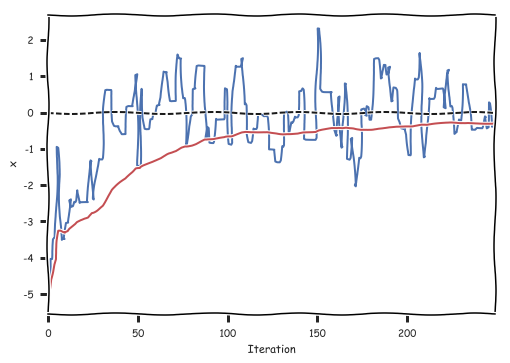

In [16]:
# traceplot in the x-dimension for first chain
traceplot(samples[0][0], 'PT_traceplot')

The traceplot shows the trademark jumps as the configurations of the chains are exchanged. 

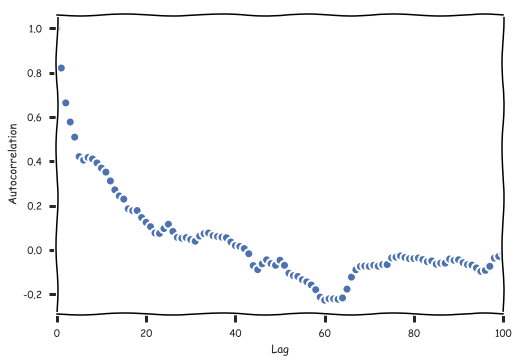

In [17]:
# autocorrelation in the x-dimension
autocorrelation_plot(samples[0][0], 100, 'PT_auto')

Let us now visualise some of the chains from the parallel tempering run. First up a chain that explores globally, then a middle of the road explorer and finally a chain that explores locally. 

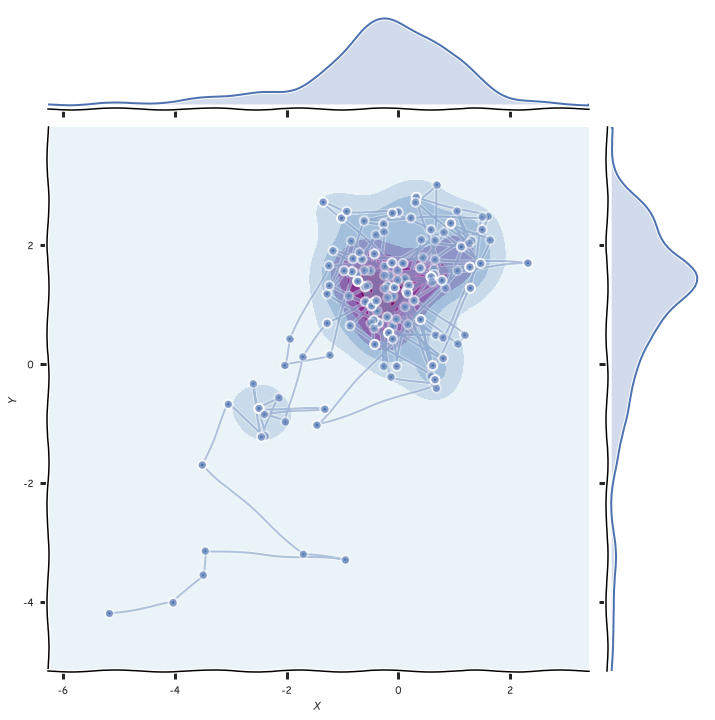

In [18]:
# the x,y data for the first chain
x1 = np.asarray(samples[0][0])
y1 = np.asarray(samples[1][0])
plot_dist(x1,y1, 'parallel_tempering_chain1')

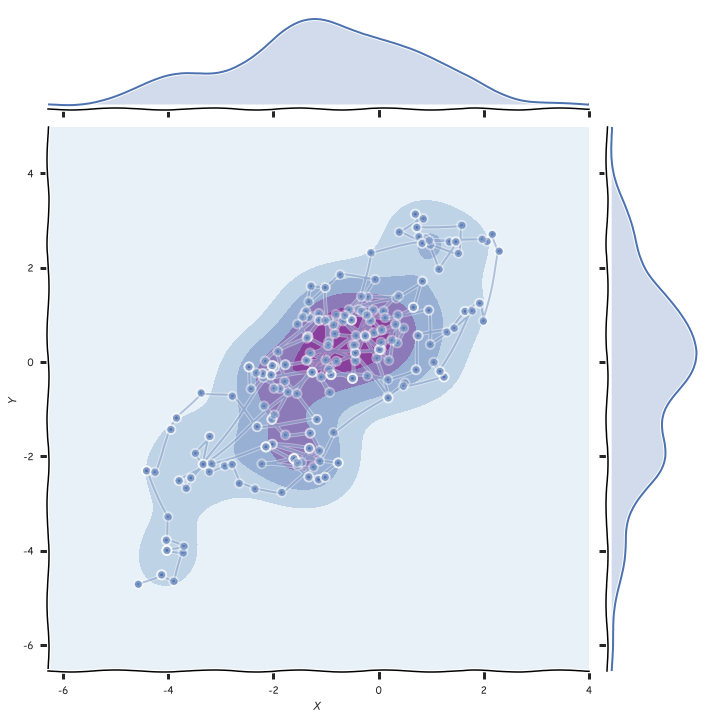

In [19]:
# the x,y data for the third chain
x3 = np.asarray(samples[0][2])
y3 = np.asarray(samples[1][2])
plot_dist(x3,y3,'parallel_tempering_chain3')

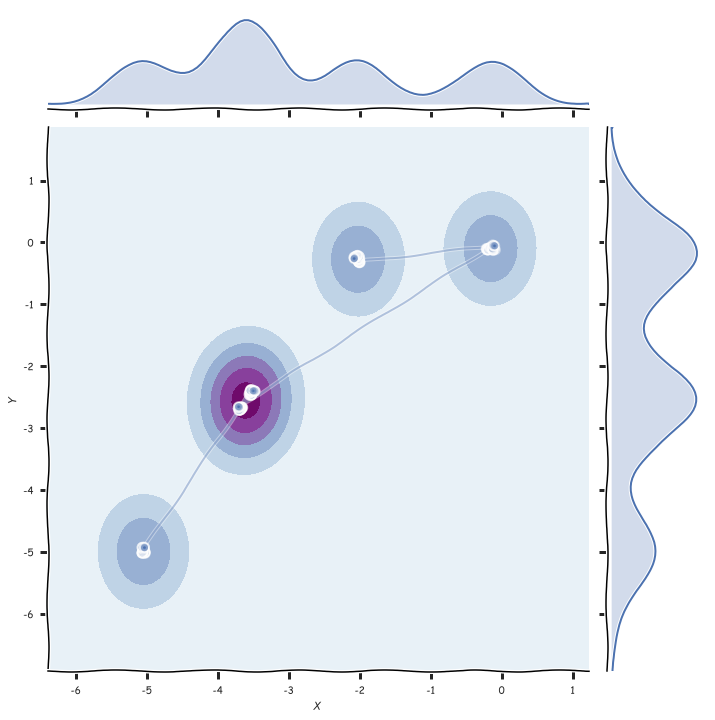

In [20]:
# the x,y data for the fifth chain
x4 = np.asarray(samples[0][4])
y4 = np.asarray(samples[1][4])
plot_dist(x4,y4, 'parallel_tempering_chain5')

We can see that the sampling patterns of the chains is quite different depending on the step size we run at. When we accept a move in the global regime we pretty much instantly snap back to the correct region whilst the local exploration is edging closer and closer towards the correct region. If we were to run this in a serious manner we would propose many more swaps than performed here, so that each chain is ergodic over the sample space. In addition it is customary to only keep the data from a single chain, most likely the global explorer. Parallel tempering therefore is useful for both optimisation *and* sampling as the information transfer between the coupled chains leads to an ergodic exploration of the posterior distribution. 

Next up on our list of MCMC algorithms is **simulated tempering** or *serial tempering*. Simulated tempering is an extension of simulated annealing and is closely related to parallel tempering. We run a single Markov chain that samples using the Metropolis-Hastings algorithm at some step-size. After a number of these updates the step size is updated by sampling a discrete distribution of step-sizes. The key difference between simulated tempering vs annealing is that the step-size could dynamically *increase* as well as decrease over the course of the process, shifting the sampling between local and global exploration. Therefore there are two new elements: the possibility to increase the step-size *and* the stochastic method of updating the step-size. 

For the update in step size, the same point $(x,y)$ is used to compute the Metropolis condition, but with the current and proposal step sizes. If the ratio of the proposal step size is greater than a random number then it is accepted. To propose a new step-size we simply choose step sizes at random from a predefined list of permissible values. 

In [21]:
import random

def simulated_tempering(p, step_sizes, n, u, x0, y0):
    '''samples p using a single Markov chain of length n
    that is updated via the Metropolis-Hastings algorithm,
    while u times the step-size is dynamically udpated
    from a distribution of potential standard deviations 
    (step_sizes) according to the Metropolis condition.'''
    
    # choose initial step_size
    step_size = random.choice(step_sizes)
    
    # append first guess to record of states
    x_list = [x0]
    y_list = [y0]
    
    # step size record
    j = 0
    update_record = []
    
    for update in range(u):
        
        for i in range(n):
        
            # propose new parameters from current state by sampling Q(x',y' | x,y)
            x_star = x_list[-1] + np.random.normal(scale=step_size)
            y_star = y_list[-1] + np.random.normal(scale=step_size)
    
            # Metropolis-Hastings condition
            if np.random.rand() < p(x_star, y_star) / p(x_list[-1], y_list[-1]):
                x_curr, y_curr = x_star, y_star
            else:
                x_curr, y_curr = x_list[-1], y_list[-1]

            # update samples list
            x_list.append(x_curr)
            y_list.append(y_curr)
            
        # update the step-size
        step_size_star = random.choice(step_sizes)
        if np.random.rand() < np.random.normal(scale=step_size_star) / np.random.normal(scale=step_size):
            step_size = step_size_star
            j += 1
            update_record.append((j, step_size))
    
    # convert lists to np array for plot environment
    x_array = np.array(x_list)
    y_array = np.array(y_list)
    
    return x_array, y_array, update_record

In [22]:
step_sizes = [0.01, 0.1, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# generate samples
samples = simulated_tempering(ptarget, step_sizes, 10, 50, -5, -5)

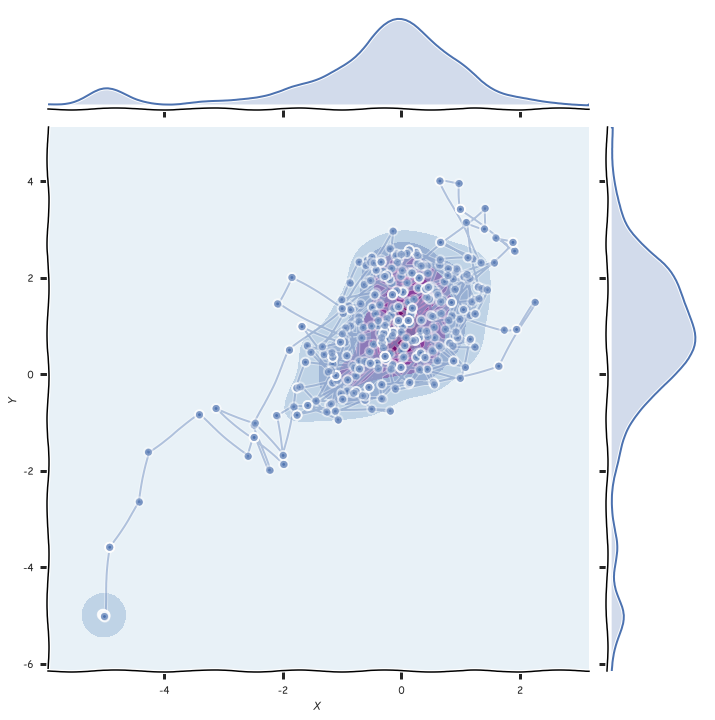

In [23]:
# visualise 
plot_dist(samples[0], samples[1], 'simulated_tempering')

In [24]:
# show the histories of the step_size
samples[2]

[(1, 0.9),
 (2, 0.8),
 (3, 0.4),
 (4, 0.3),
 (5, 0.8),
 (6, 1.0),
 (7, 0.3),
 (8, 0.4),
 (9, 1.0),
 (10, 0.4),
 (11, 0.5),
 (12, 0.4),
 (13, 0.2),
 (14, 0.8),
 (15, 0.9),
 (16, 0.8),
 (17, 0.8),
 (18, 0.4)]

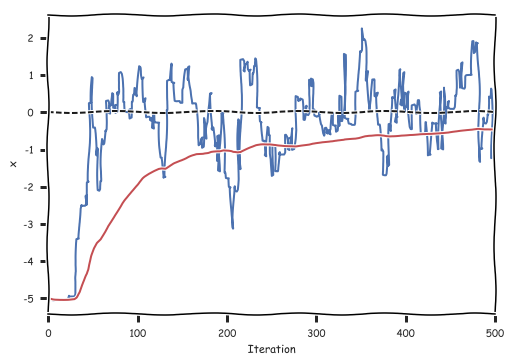

In [25]:
# traceplot in the x-dimension
traceplot(samples[0],'ST_traceplot')

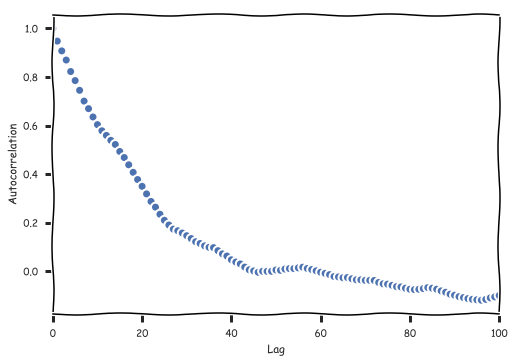

In [26]:
# autocorrelation in the x-dimension
autocorrelation_plot(samples[0], 100, 'ST_auto')

We can see that simulated tempering quickly finds the region of concentrated measure. The benifit of this method over simulated annealing is that the exploration should never become stuck in a region of sub-optimal measure, something which a poor choice of annealing schedule can lead to. The downside of this method is in choosing the distribution of the step-size and how to weight each choice. In our simple case we didn't encounter this problem since we chose a Metropolis version of the Metropolis-Hastings algorithm, but for most cases this limits its use. So whilst on the surface of things simulated tempering appears to be a good mix between an optimisation algorithm and a sampler, it is easier to use either simualted annealing *or* parallel tempering in all but the simplest of cases. 

The next algorithm we will explore is the **Gibbs sampler**. Gibbs sampling is actually a generic term for a collection of related sampling algorithms. It is useful when we can't sample from the joint distribution $\pi(\boldsymbol \theta)$ but *can* sample from the conditional distributions $\pi(\theta_i\mid \theta_1,\dots \theta_{i-1}, \theta_{i+1}, \dots ,\theta _N)$. That might seem a bit strange at first, but it actually simplifies a lot of scenarios, since in many cases we know the analytical form of a single component if we had knowledge of all the others! Of course this is also the pitfall of the Gibbs sampling method, since we must have knowledge of the conditional distributions analytically. 

The idea is that we pick a dimension $i$ and sample from the conditional distribution for that parameter before iterating over all the dimensions $i \in 1, \dots ,N$. In our case we have a bivariate joint probability density $\pi(x,y)$. Pretending that we can't sample directly from this we instead sample the distribution of $x$ keeping $y$ fixed at some guess, in the next iteration we sample from a distribution of $y$ keeping $x$ fixed. This is cycle through the parameter vector and hence one cycle of the Gibbs sampler. We then iterate to a set number of cycles.

Unlike any of our previous sampling algorithms we *always* accept the proposals made in the parameter updates. This is because the proposal distributions *are* the conditional posteriors in each parameter. Whilst in Metropolis-Hastings we propose a distribution and sample from it, in Gibbs sampling we actually have access to the real thing. In the Metropolis-Hastings sampler we do not have knowledge of the full conditional distributions, thats okay though because they cancel in the acceptance criteria. 

We can see this analytically from the Metropolis-Hastings criteria for each update how this leads to an acceptance criteria of exactly one. We first write out the Metropolis-Hastings criteria before decomposing $Q$s into the conditional distribution $\pi(\theta_i\mid \theta_1^{(t)},\dots \theta_{i-1}^{(t)}, \theta_{i+1}^{(t-1)}, \dots ,\theta _N^{(t-1)})$. 

$$
\begin{align}
A(\theta' \mid \theta) &= \min \left( 1, \frac{\pi(\theta'\mid x)}{\pi(\theta\mid x)}\frac{Q(\theta\mid \theta')}{Q(\theta'\mid \theta)}\right)
\end{align}
$$

then,

$$ 
\begin{align}
&=\frac{\pi\big( \theta _1 ^{(t)}, \dots , \theta^{(t)}_{i-1}, \theta_i, \theta_{i+1}^{(t-1)}, \dots , \theta_N^{(t-1)}\big) \pi\big(\theta_i^{(t-1)}\mid \theta_1^{(t)},\dots ,\theta^{(t)}_{i-1}, \theta ^{(t-1)}_{i+1},\dots,\theta_N^{(t-1)}\big)}  {\pi\big(\theta^{(t)}_1, \dots,\theta^{(t)}_{i-1}, \theta_i^{(t-1)} , \theta_{i+1}^{(t-1)},\dots ,\theta_N^{(t-1)}\big) \pi \big( \theta_i\mid \theta_1^{(t)}, \dots ,\theta^{(t)}_{i-1}, \theta_{i+1}^{(t-1)},\dots, \theta_N^{(t-1)}\big)}
\end{align}
$$

and finally, 

$$ 
\begin{align}
&= \frac{\pi\big(\theta_1^{(t)}, \dots ,\theta^{(t)}_{i-1},\theta _i, \theta_{i+1}^{(t-1)},\dots , \theta_N^{(t-1)}\big) \frac{\pi(\theta_1^{(t)}, \dots, \theta^{(t)}_{i-1},\theta ^{(t-1)}_i, \theta^{(t-1)}_{i+1},\dots,\theta_N^{(t-1)})}{\pi(\theta_1^{(t)},\dots,\theta^{(t)}_{i-1},\theta^{(t-1)}_{i+1}, \dots,\theta_N^{(t-1)})}}  {\pi\big(\theta_1^{(t)}, \dots, \theta^{(t)}_{i-1}, \theta_i^{(t-1)}, \theta_{i+1}^{(t-1)}, \dots, \theta_N^{(t-1)}\big) \frac{\pi(\theta^{(t)}_1,\dots \theta^{(t)}_{i-1},\theta_i,\theta_{i+1}^{(t-1)},\dots, \theta_N^{(t-1)})}{\pi(\theta^{(t)}_1,\dots,\theta^{(t)}_{i-1},\theta^{(t-1)}_{i+1}, \dots, \theta_N^{(t-1)})}}\\
&=1
\end{align}
$$

(and yes that was hard work to type out). Here the $(t)$ notation replaces the dash notation for the current and proposal states. Anyway ... thats enough maths! We will now implement Gibbs sampling for our bivariate normal distribution. In this case the conditional distributions are given by two univariate normals: 

$$
Q(\theta_1\mid \theta_2^{(t-1)}) = \mathcal N(\mu_1 + \rho_{21}(\theta_2^{(t-1)} -\mu_2), \sqrt{1-\rho_{21}^2})
$$

$$
Q(\theta_2\mid \theta_1^{(t)}) = \mathcal N(\mu_2 + \rho_{12}(\theta_1^{(t)} -\mu_1), \sqrt{1-\rho_{12}^2})
$$

In [27]:
def gibbs_sampler(mean, var, n, x0, y0):
    '''Gibbs sampling algorithm for bivariate normal distribution. 
    The conditional distributions for the parameters are sequentially
    sampled and '''
    
    # first guess
    x = x0
    y = y0
    
    x_samples = [x]
    y_samples = [y]

    for i in range(n):
        
        # sample x given y
        x = Q_x_mid_y(y, mean, var)
        
        # sample y given x
        y = Q_y_mid_x(x, mean, var)
        
        # append samples with update
        x_samples.append(x)
        y_samples.append(y)

    return x_samples, y_samples

In [28]:
def  Q_x_mid_y(y, mean, var):
    '''The conditional of x given y. In this case a univariate normal'''
    m = mean[0] + var[1, 0] / var[0, 0] * (y - mean[1])
    v = var[0, 0] - var[1, 0] / var[1, 1] * var[1, 0]
    return np.random.normal(m, v)


def Q_y_mid_x(x, mean, var):
    '''The conditional of y given x. In this case a univariate normal'''
    m = mean[1] + var[0, 1] / var[1, 1] * (x - mean[0])
    v = var[1, 1] - var[0, 1] / var[0, 0] * var[0, 1]
    return np.random.normal(m, v)

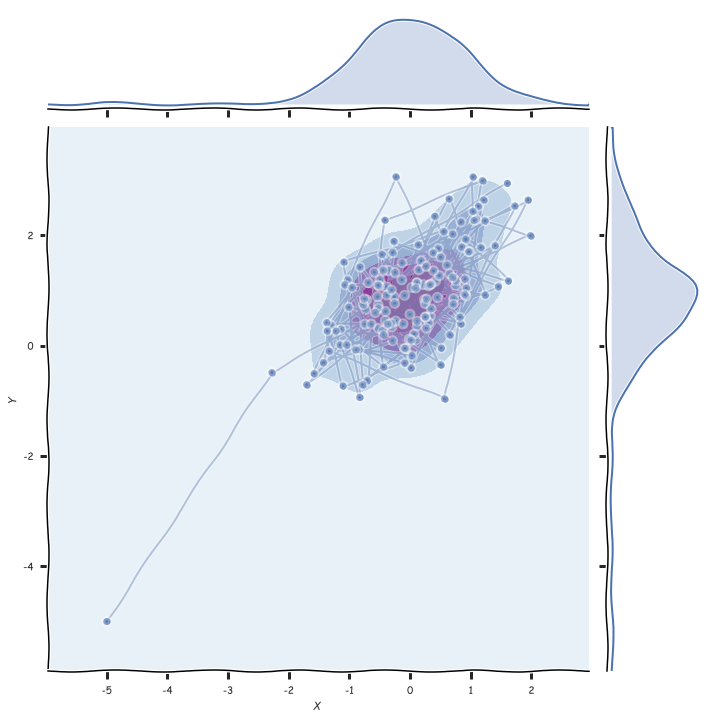

In [29]:
# produce samples
samples = gibbs_sampler(mean, var, 150, -5, -5)

# convert lists to arrays
x = np.asarray(samples[0])
y = np.asarray(samples[1])

# visualise 
plot_dist(x, y, 'Gibbs')

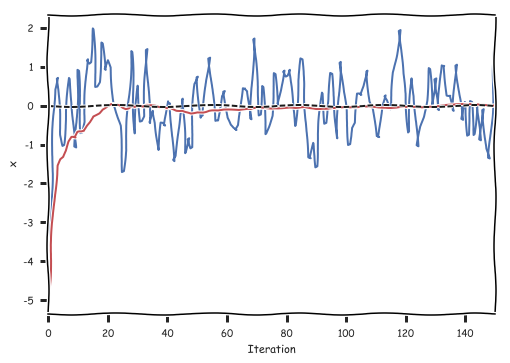

In [30]:
# traceplot in the x-dimension
traceplot(x, 'G_traceplot')

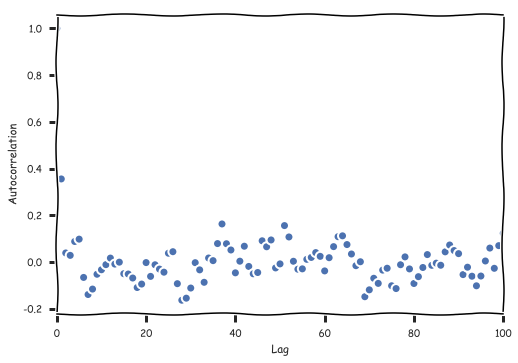

In [31]:
# autocorrelation in the x-dimension
autocorrelation_plot(x, 100, 'G_auto')

We see that the Gibbs sampler is extremely efficient at getting to the correct region quickly (low burn in period) and once there it samples our distribution well. The drawback of this method is simply the access to the conditional distribution in the first place. If these are not able to be found then we cannot use this method. Earlier we remarked that there is a whole family of Gibbs algorithms. If only *some* of the parameters have analytical conditional distributions then we can sample the others with regular Metropolis-Hastings sampling and then the ones we do have with the Gibbs method. The implementations of this can vary however from the standard algorithm presented here! 

# Conclusions

Well I hope you have had fun with some MCMC algorithms, I know I certainly have. In future posts I would like to explore more theory of the methods and write robust examples of each of the samplers in our toolkit! There are plenty more MCMC sampling algorithms out there, an important one is called Hamiltonian Monte Carlo and we will definitly be looking at this at some point. 